In [1]:
import glob2
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = glob2.glob("train/*")
species = []
for f in files:
    species.append(f[6:]) # birds species list

Definition to create array of bird species catalogues

In [3]:
def get_species_dataset(directory, species_count = None, img_count = None):
                                # reduced number of species and images per specie
    target = []

    zero = glob2.glob(os.path.join(directory, species[0])+"/*")[0]
    zero_img = cv2.cvtColor(cv2.imread(zero),cv2.COLOR_BGR2RGB).reshape(1,224,224,3)

    for specie in species[:species_count]:
        specie_id = species.index(specie)
        specie_imgs = glob2.glob(os.path.join(directory, specie)+"/*")

        if not img_count:
            img_count = len(specie_imgs)
            
        for img in specie_imgs[:img_count]:
            tmp_img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB).reshape(1,224,224,3)
            
            if specie == species[0] and img == specie_imgs[0]:
                dataset = zero_img
                
            else:
                dataset = np.concatenate((dataset, tmp_img ), axis=0)

            target.append(specie_id)
            
    target_arr = np.array(target).reshape(-1,1)

    print("            dataset shape:", dataset.shape)
    print("             target shape:", target_arr.shape)
    print("target classes and counts:", dict((i, target.count(i)) for i in target))

    return dataset, target_arr

Dataset for DL training

In [4]:
num_class = 10


In [5]:
x_train, y_train = get_species_dataset("train", num_class)

            dataset shape: (1507, 224, 224, 3)
             target shape: (1507, 1)
target classes and counts: {0: 166, 1: 166, 2: 166, 3: 137, 4: 146, 5: 137, 6: 130, 7: 133, 8: 161, 9: 165}


In [6]:
x_test, y_test = get_species_dataset("test", num_class)
# x_val, y_val = get_species_dataset("valid", num_class)


            dataset shape: (50, 224, 224, 3)
             target shape: (50, 1)
target classes and counts: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5}


In [7]:
import tensorflow as tf

In [8]:
from tensorflow.keras import layers

def create_cnn_model(inShape, convNum, hNum, hAct, outNum, loss):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość
    :param loss: funkcja kosztu
    """
    # pusty model
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=(inShape)))
    # warstwy konwolucyjne
    for idx, oneConvNum in enumerate(convNum):
        # dodajemy kolejną warstwę konwolucyjną
        # zmienia nam ilość cech(kanałów) na oneConvNum
        model.add(layers.Conv2D(
                                filters=oneConvNum,
                                kernel_size=3,
                                strides=1,
                                padding="SAME",
                                activation="relu"
                                )
                            )
        # doajemy następującego po convie maxpool'a
        # zmniejsza nam wymiarowość HxW o połowę
        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )
    # spłaszczamy po konwolucjach, przygotowanie pod relu
    model.add(layers.Flatten())
    # warstwy fully connected
    for idx, oneHidNum in enumerate(hNum):
        # dodajemy warstwę
        model.add(layers.Dense(oneHidNum, activation=hAct))
    # warstwa wyjściowa
    model.add(layers.Dense(outNum))
    # warstwa softmax, dystrybucja prawdopodobieństwa
    model.add(layers.Softmax())
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
    
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy"]
    )
    
    return model

In [9]:
our_cnn = create_cnn_model(
    inShape=(224, 224, 3),
    convNum=[8,16,24,32,40],
    hNum=[50],
    hAct='relu',
    outNum=num_class,
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 24)        3480      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 24)       0

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [11]:
history = our_cnn.fit(
    x=x_train,
    y=y_train,
    epochs=100,
    batch_size=1024,
    validation_data=(x_test,  y_test),
    callbacks=[callback]
)

Epoch 1/100
2/2 [==============================] - 19s 6s/step - loss: 14.6498 - accuracy: 0.0995 - val_loss: 14.5245 - val_accuracy: 0.1000
Epoch 2/100
2/2 [==============================] - 17s 5s/step - loss: 12.7176 - accuracy: 0.0883 - val_loss: 5.8721 - val_accuracy: 0.0800
Epoch 3/100
2/2 [==============================] - 16s 5s/step - loss: 5.6960 - accuracy: 0.0896 - val_loss: 4.2731 - val_accuracy: 0.0400
Epoch 4/100
2/2 [==============================] - 16s 5s/step - loss: 3.9964 - accuracy: 0.1354 - val_loss: 3.1122 - val_accuracy: 0.1200
Epoch 5/100
2/2 [==============================] - 16s 6s/step - loss: 2.9702 - accuracy: 0.1208 - val_loss: 2.6311 - val_accuracy: 0.0800
Epoch 6/100
2/2 [==============================] - 16s 5s/step - loss: 2.5460 - accuracy: 0.1221 - val_loss: 2.4301 - val_accuracy: 0.1000
Epoch 7/100
2/2 [==============================] - 17s 5s/step - loss: 2.3713 - accuracy: 0.1466 - val_loss: 2.3387 - val_accuracy: 0.1200
Epoch 8/100
2/2 [=======

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

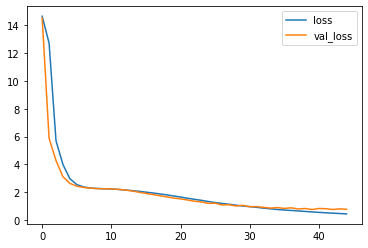

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

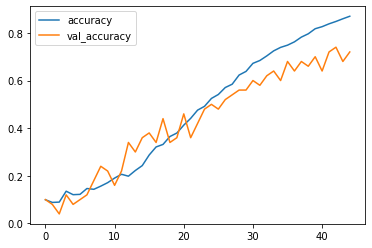

In [14]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [15]:
our_cnn.save_weights("weights/model_for_fun")
our_cnn.save("model/simple.h5")

Loading of the model weights directly into the model

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
model_loaded = create_cnn_model(
    inShape=(224, 224, 3),
    convNum=[8,16,24,32,40],
    hNum=[50],
    hAct='relu',
    outNum=10,
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 24)        3480      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 24)      

In [18]:
# wczytuje parametry do zainicjalizowanego modelu
model_loaded.load_weights("weights/model_for_fun")

In [19]:
# tu wrzucasz dane do predict które chcesz sprawdzić
y_pred = model_loaded.predict(x_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.44      0.80      0.57         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       0.83      1.00      0.91         5
           5       0.75      0.60      0.67         5
           6       0.80      0.80      0.80         5
           7       1.00      0.40      0.57         5
           8       0.60      0.60      0.60         5
           9       0.80      0.80      0.80         5

    accuracy                           0.72        50
   macro avg       0.76      0.72      0.72        50
weighted avg       0.76      0.72      0.72        50



Loading whole model (model with the weights)

In [20]:
def read_images_from_directory(directory):
    test_imgs = glob2.glob(os.path.join(directory)+"/*")
    zero_img = cv2.cvtColor(cv2.imread(test_imgs[0]),cv2.COLOR_BGR2RGB).reshape(1,224,224,3)
    filenames = [test_imgs[0]]
    dataset = zero_img
    
    for img in test_imgs[1:]:
            tmp_img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB).reshape(1,224,224,3)
            dataset = np.concatenate((dataset, tmp_img), axis=0)
            filenames.append(img)

    return dataset, filenames

In [21]:
model_loaded_h5 = tf.keras.models.load_model("model/simple.h5")

In [24]:
images_to_predict, filenames = read_images_from_directory('images_to_test')
y_pred = model_loaded_h5.predict(images_to_predict)
for index, pred in enumerate(y_pred):
    print(f'Picture {filenames[index]} is {species[pred.argmax()]} with {pred.max():.2f}% confidence')

Picture images_to_test\1.jpg is AFRICAN FIREFINCH with 0.53% confidence
Picture images_to_test\2.jpg is AFRICAN CROWNED CRANE with 0.76% confidence
Picture images_to_test\3.jpg is ALEXANDRINE PARAKEET with 0.99% confidence
Picture images_to_test\4.jpg is AFRICAN CROWNED CRANE with 0.71% confidence
Picture images_to_test\5.jpg is ALEXANDRINE PARAKEET with 0.97% confidence
